In [2]:
import math
import numpy.linalg as linalg
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import List

### Now we will put everything together into our own NueralNetwork class! I've copied the functions we derived in the last tutorial over, along with some helper functions for setting the network up given some layer dimensions and learning rate.

In [4]:
# We still use tanh as our sigmoid curve

def sigmoid(z):
  return np.tanh(z)

def sigmoid_prime(z):
  return np.diag(1 - np.power(np.tanh(z), 2))

class NeuralNetwork:

    layer_dimensions: List[int] = []
    inner_layers: int = 0
    learning_rate: float = 0

    weights: List[np.ndarray] = []
    biases: List[np.ndarray] = []

    def __init__(self, layer_dimensions: List[int], learning_rate: float):
        self.layer_dimensions = layer_dimensions
        self.inner_layers = len(layer_dimensions) - 1
        self.learning_rate = learning_rate

        self.randomize_parameters()
    
    def get_layer_dimension(self, dimension: int) -> int:

        return self.layer_dimensions[dimension]

    # For now, we initialize our parameters uniformly randomly, negatively or positively.
    def randomize_parameters(self):
        
        self.weights = []
        self.biases = []

        for layer in range(1, self.inner_layers+1):

            last_dim = self.get_layer_dimension(layer - 1)
            this_dim = self.get_layer_dimension(layer)

            self.weights.append(np.random.rand(this_dim, last_dim))
            self.biases.append(np.random.rand(this_dim))

    # Run the nueral net forwards
    def run(self, input: List[int]) -> List[int]:
        acc = input
        for layer in range(0, self.inner_layers):
            acc = sigmoid(self.weights[layer] @ acc + self.biases[layer])
        return acc
    
    # Run the nueral net forwards to a specific layer
    def run_to_layer(self, input: List[int], to_layer: int) -> List[int]:
        assert(to_layer <= self.inner_layers)
        acc = input
        for layer in range(0, to_layer):
            acc = sigmoid(self.weights[layer] @ acc + self.biases[layer])
        return acc

    # Get the cost of some input and expected output
    def get_cost(self, inputs: List[int], expected_output: List[int]) -> float:
        return 0.5 * np.linalg.norm(self.run(inputs) - expected_output) ** 2

    # Compute the gradients and take a step to descend according to the learning rate.
    def train(self, input: List[int], expected_output: List[int]):
        bias_gradients: List[np.ndarray] = []
        weight_gradients: List[np.ndarray] = []

        for layer in range(0, self.inner_layers):
            bias_gradients.append(self.get_cost_gradient_bias(input, expected_output, layer))
            weight_gradients.append(self.get_cost_gradient_weight(input, expected_output, layer))
        
        for layer in range(0, self.inner_layers):
            self.biases[layer] -= self.learning_rate * bias_gradients[layer]
            self.weights[layer] -= self.learning_rate * weight_gradients[layer]

    # All the methods below are just carried over from the last tutorial.
    # Note that right now, these methods are recursive and slow! We will improve them next tutorial!

    def get_cost_gradient_bias(self, input: List[int], expected_output: List[int], target_layer: int) -> np.ndarray:
        return self.__rec_gradient_helper(input, self.inner_layers-1, target_layer) @ (self.rec_run_helper(input, self.inner_layers-1, 0) - expected_output)

    def get_cost_gradient_weight(self, input: List[int], expected_output: List[int], target_layer: int) -> np.ndarray:
        return np.outer(self.__rec_gradient_helper(input, self.inner_layers-1, target_layer) @ (self.rec_run_helper(input, self.inner_layers-1, 0) - expected_output), self.rec_run_helper(input, target_layer-1, 0))

    def __rec_gradient_helper(self, input: List[int], current_layer: int, target_layer: int) -> np.ndarray:
        if current_layer == target_layer:
            return sigmoid_prime(self.weights[current_layer] @ self.rec_run_helper(input, current_layer-1, 0) + self.biases[current_layer])
        else:
            return self.__rec_gradient_helper(input, current_layer-1, target_layer) @ self.weights[current_layer].transpose() @ sigmoid_prime(self.weights[current_layer] @ self.rec_run_helper(input, current_layer-1, 0) + self.biases[current_layer])
        
    def rec_run_helper(self, input: List[int], current_layer: int, target_layer: int) -> np.ndarray:
        if current_layer == target_layer - 1:
            return input
        else:
            return sigmoid(self.weights[current_layer] @ self.rec_run_helper(input, current_layer-1, target_layer) + self.biases[current_layer])


### So, let's try it out! We set up a simple nueral network and run it on some inputs!

In [6]:
network = NeuralNetwork([4, 4, 4], 0.01)

inp = [1,2,3,4]
print(network.run(inp))
print(network.rec_run_helper(inp, 1, 0))

[0.99257541 0.9789406  0.88652292 0.8804937 ]
[0.99257541 0.9789406  0.88652292 0.8804937 ]


In [7]:
inp = [1,2,3,4]
expected = [1,2,3,4]
print(network.get_cost(inp, expected))

7.620361165613577


### This code trains our nueral net on the identity function, then prints our old cost and our new cost to prove that the cost *is* going down with more training iterations.

In [8]:
test_case = [0.5, 0.3, -0.3, 0.3]
old_test_cost = network.get_cost(test_case, test_case)

for i in range(0, 10000):
    inp = np.random.randn(4)
    
    old_cost = network.get_cost(inp, inp)
    network.train(inp, inp)
    new_cost = network.get_cost(inp, inp)
    if new_cost > old_cost:
        print("network got worse by training, something is wrong!")

new_test_cost = network.get_cost(test_case, test_case)
print(str(old_test_cost) + " -> " + str(new_test_cost))

0.9628990154263708 -> 0.04068095625549654


### Training on the identity function, we should expect that our biases are very small, and indeed they are:

In [ ]:
print(network.biases)
print(network.weights)

[array([ 0.01072911, -0.01281206, -0.01105854,  0.03361699]), array([-0.00594956, -0.00985963, -0.05956552,  0.00456766])]
[array([[ 0.63890215, -0.10879878, -0.02749618,  0.02605715],
       [-0.00826312,  0.21156856, -0.04513123,  0.59651925],
       [ 0.05882187,  0.57497371,  0.02973209, -0.19151482],
       [ 0.02371398, -0.03289466,  0.66827189,  0.06548061]]), array([[ 2.34661563,  0.01501818,  0.48718386,  0.09339001],
       [-0.34027738,  0.92632535,  2.33572433, -0.08612396],
       [-0.1700803 , -0.23843178,  0.18931169,  2.29060454],
       [ 0.1575392 ,  2.30930688, -0.9000997 ,  0.23125458]])]


### As in the first tutorial, we set up data to train our network on:

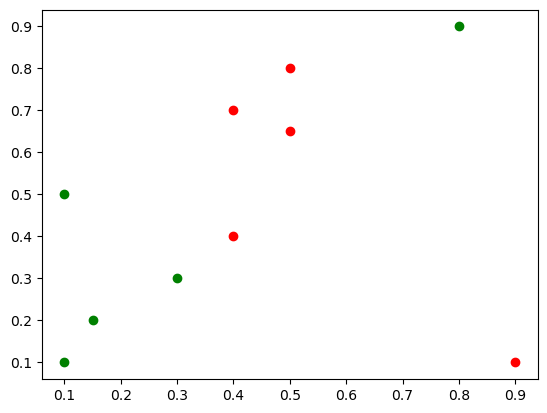

In [9]:
data = [
    (0.1, 0.1, True), 
    (0.1, 0.5, True), 
    (0.3, 0.3, True), 
    (0.15, 0.2, True), 
    (0.8, 0.9, True), 
    (0.4, 0.4, False), 
    (0.5, 0.65, False), 
    (0.5, 0.8, False),
    (0.4, 0.7, False),
    (0.9, 0.1, False)
]

#def Cost(params):
#    return CostForData(data, params)

yesData = list(filter(lambda p: p[2], data))
noData = list(filter(lambda p: not p[2], data))

plt.scatter(list(map(lambda p: p[0], yesData)), list(map(lambda p: p[1], yesData)), c='g')
plt.scatter(list(map(lambda p: p[0], noData)), list(map(lambda p: p[1], noData)), c='r')

### Then we train the network! We print the cost over each step, showing how it goes down with more training iterations:

In [10]:
network = NeuralNetwork([2, 3, 3, 2], 0.1)
network.randomize_parameters()

for i in range(0, 1000):
    random.shuffle(data)

    for d in data:
        network.train([d[0], d[1]], [1, 0] if d[2] else [0, 1])

    total_cost_after = 0
    for d in data:
        total_cost_after += network.get_cost([d[0], d[1]], [1, 0] if d[2] else [0, 1])
    print(total_cost_after)

    

3.260365391384478
2.7178823482956087
2.6245788399162246
2.5466040117111413
2.7145595873504855
2.7591707363145397
2.5313065366651344
2.5232471782424257
2.632594746647108
2.5472164910714605
2.546165282898452
2.53069403540513
2.499151497968043
2.4932869472392
2.4916840708044647
2.4994524884195166
2.4969158357887467
2.493942155749784
2.4706552492099703
2.4764871174681127
2.5202895603096236
2.489236805660882
2.48017513782221
2.4978821476340376
2.5432295118778
2.458974354924856
2.4892017846961205
2.550322570275843
2.5027428487185697
2.5132695840348562
2.441213935936304
2.417136993888584
2.4366244022660632
2.4193161835577186
2.4709145333980236
2.386660111195738
2.4011477105801022
2.3770313619262393
2.4007094360759678
2.3697627781141497
2.3425029018673857
2.3855098543314277
2.3476139865423753
2.304204728065263
2.4134587788464428
2.4062371125946216
2.4420332332329915
2.228991917427936
2.2543969288838617
2.1828832732763472
2.1652101838332607
2.1252244103529074
2.0871038930169967
2.07689083738316

### As before, we can plot our results:

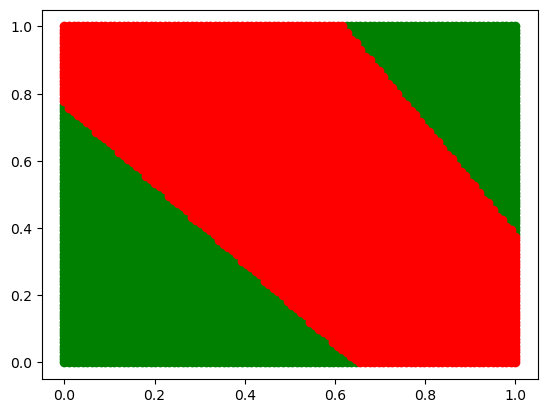

In [11]:


domain = []
for (i, input) in enumerate(np.linspace(0, 1, 100)):
    for (j, y) in enumerate(np.linspace(0, 1, 100)):
        domain.append([input, y])

yesDomain = []
noDomain = []
for d in domain:
    result = network.run(d)
    
    if result[0] < result[1]:
        noDomain.append(d)
    else:
        yesDomain.append(d)

plt.scatter(list(map(lambda p: p[0], yesDomain)), list(map(lambda p: p[1], yesDomain)), c='g')
plt.scatter(list(map(lambda p: p[0], noDomain)), list(map(lambda p: p[1], noDomain)), c='r')

### To put it all together, below is an interactive demo where you can left-click to add one group of points, and right click to add the other. Our model is then quickly trained on those inputs. Try playing around with more layers or different learning rates and seeing what happens!

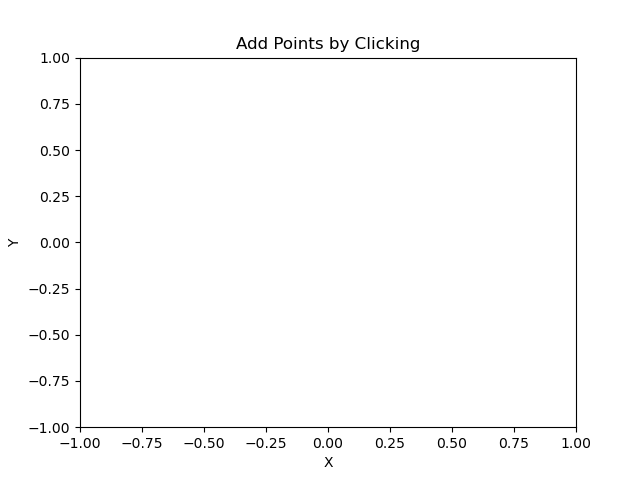

In [12]:
%matplotlib widget

import matplotlib.pyplot as plt
import mplcursors

training_iterations = 500
learning_rate = 0.1
layers = [2, 3, 3, 2]
domain_spacing = 25

red_points = []
blue_points = []

# Function to add point on click event
def onclick(event):

    plt.clf()

    if event.button == 1:  # Left click
        red_points.append([event.xdata, event.ydata])
    elif event.button == 3:  # Right click
        blue_points.append([event.xdata, event.ydata])

    network = train_network(red_points, blue_points)
    domain = []
    dl = 2 / domain_spacing
    for (i, input) in enumerate(np.linspace(-1, 1, domain_spacing)):
        for (j, y) in enumerate(np.linspace(-1, 1, domain_spacing)):
            domain.append([input, y])
    
    for d in domain:
        result = network.run(d)
        
        color = 'red' if result[0] < result[1] else 'green'
        plt.fill([d[0], d[0], d[0]+dl, d[0]+dl], [d[1], d[1]+dl, d[1]+dl, d[1]], color=color, alpha=0.25)

    plt.scatter([p[0] for p in red_points], [p[1] for p in red_points], color='red')
    plt.scatter([p[0] for p in blue_points], [p[1] for p in blue_points], color='blue')

    plt.draw()

def train_network(red_points, blue_points) -> NeuralNetwork:
    network = NeuralNetwork(layers, learning_rate)
    network.randomize_parameters()

    data = [(point[0], point[1], False) for point in red_points] + [(point[0], point[1], True) for point in blue_points]
    for i in range(0, training_iterations):
        random.shuffle(data)

        for d in data:
            network.train([d[0], d[1]], [1, 0] if d[2] else [0, 1])

        total_cost_after = 0
        for d in data:
            total_cost_after += network.get_cost([d[0], d[1]], [1, 0] if d[2] else [0, 1])
        # todo label this on the graph somehow?
    
    return network

# Create a figure and plot
fig, ax = plt.subplots()
ax.plot([], [])
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

# Connect the onclick event to the figure
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# Add labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Add Points by Clicking')

# Show the plot
plt.show()


### Unfortunately, our network is quite slow right now. In the next tutorial, we'll show how to optimize our backpropagation code to speed up it up.